# **Scraping 🎀**

In [ ]:
import selenium 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
from html import unescape

# Set up Chrome driver
driver = webdriver.Chrome()
wait = WebDriverWait(driver, 10)

# Define the mapping lists 
mapping_lists = {
    "Face": {
        "Primer":               ["primer", "pore", "sunburst"],
        "Concealer":            ["concealer"],
        "Foundation":           ["foundation"],
        "Blush":                ["blush", "festive", "cheeky", "use balm", "lip cream"],
        "Highlighter":          ["highlighter", "highlighting", "glow stick", "shimmer", "eye pencil"],
        "Setting Spray":        ["spray"],
        "Powder":               ["powder"],
        "Palette":              ["palette"],
        "Contour & Bronzer":    ["bronzer", "contour", "tan", "sun", "pen-light", "dark", "nude", "sand","bronzing"],
    },
    "Eyes": {
        "Eyeliner":             ["eyeliner", "liner", "wand"],
        "Eyeshadow":            ["eyeshadow", "tone shadow", "jelly", "glitter", "flake"],
        "Eyeshadow Palette":    ["palette", "stack"],
        "Mascara":              ["mascara"],
        "Eyebrow":              ["brow", "eyebrow", "control hair"],
        "Lashes":               ["lash", "lashes"],
        "Eye Primer":           ["under eye"],
    },
    "Lips": {
        "Lipstick":             ["lipstick","Lip Set","stacks"],
        "Lip Gloss":            ["gloss","Hydra Jelly","care","Mask","oil","Soft","jam"],
        "Lip Liner":            ["liner","marker","duo"],
        "Lip Balm":             ["balm"],
        "Lip Kit":              ["kit"],
        "Lip Plumper":          ["lip plumper"],
        "Lip Tint":             ["lip tint","Cheek Tint"]
    },
    "Tools & Others": {
        "Brush Set":            ["brush set"],
        "Brush":                ["brush"],
        "Sponge":               ["sponge"],
        "Puff":                 ["puff"],
        "Makeup Bag":           ["bag"],
        "Mirror":               ["mirror"],
        "Brush Cleaner":        ["cleaner"],
        "Eyelash Tool":         ["eyelash"],
        "Eyelash Curler":       ["curler"],
        "Brows & Lash Tools":   ["mermaid"],
        "Facial Cleaning Tools":["mattifying"],
        "Eyelashes and Adhesives Kits":["Magnetizing Eyes"]
    },
    "Hair Tools": {
        "Hair Straightener Iron":          ["straightener"],
        "Hot-Air Brushes & Straight Hair Combs": ["sleek", "blowout", "straight-combs"],
        "Curling Tongs & Curling Wands":   ["curler", "curling", "curl", "iron"],
    },
    "Hair Care": {
        "Hair Treatment":        ["thermal", "glow", "leave-in", "oil"],
        "Hair Coloring":         ["dye"],
        "Styling Products":      ["Hold"]
    },
}

# Build the final keyword→subcategory map used in matching
subcategory_keywords = {
    cat: {
        kw.lower(): subcat
        for subcat, keywords in mapping_lists[cat].items()
        for kw in keywords
    }
    for cat in mapping_lists
}

data = []
best_seller_products = set()

def click_main_view_more():
    while True:
        try:
            btn = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, ".fun-pc-std-list-showMore button")))
            driver.execute_script("arguments[0].click()", btn)
            time.sleep(2)
        except:
            break

def get_product_details(el):
    d = {"Name": "N/A", "Price": "N/A", "Stars": 0.0}
    try:
        d["Name"] = unescape(el.find_element(By.CSS_SELECTOR, ".fun-pc-sg-goods-cell-name").text.strip())
    except: pass
    try:
        d["Price"] = el.find_element(By.CSS_SELECTOR, ".fun-pc-sg-goods-cell-salePrice").text.strip()
    except: pass
    try:
        stars = 0.0
        for star in el.find_elements(By.CSS_SELECTOR, ".fun-pc-std-rate-active"):
            pct = star.get_attribute("style").split(":")[1].replace("%","").replace(";","")
            stars += int(pct)/100
        d["Stars"] = stars
    except: pass
    return d

def match_nlp_attributes(name, category):
    nm = name.lower()
    for kw, subcat in subcategory_keywords.get(category, {}).items():
        if kw in nm:
            return subcat
    return "N/A"

def scrape_category(category_name):
    print(f"Scraping category: {category_name}")
    wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, ".fun-pc-sg-goods-cell-wrapper")))
    click_main_view_more()
    
    products = driver.find_elements(By.CSS_SELECTOR, ".fun-pc-sg-goods-cell-wrapper")
    for idx, prod in enumerate(products, 1):
        driver.execute_script("arguments[0].scrollIntoView()", prod)
        time.sleep(0.1)
        details = get_product_details(prod)
        
        if category_name == "Hair Tools":
            try:
                href = prod.find_element(By.TAG_NAME, "a").get_attribute("href")
                driver.execute_script("window.open('{}')".format(href))
                driver.switch_to.window(driver.window_handles[-1])
                wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, ".style_mainAttrTitle__OV5Ab")))
                plug_el = driver.find_element(
                    By.XPATH,
                    "//div[contains(@class,'style_mainAttrTitle__OV5Ab')]" +
                    "/span[contains(text(),'Plug(Voltage):')]/following-sibling::span"
                )
                plug = plug_el.text.strip()
                details["Name"] += f" [{plug}]"
            except:
                pass
            finally:
                driver.close()
                driver.switch_to.window(driver.window_handles[0])

        subcat = match_nlp_attributes(details["Name"], category_name)
        data.append({
            "Category":   category_name,
            "Name":       details["Name"],
            "Price":      details["Price"],
            "Stars":      round(details["Stars"],1),
            "Subcategory":subcat,
            "Best Seller":0
        })

# Start from homepage
driver.get("https://www.sheglam.com/")
time.sleep(2)


# Click through main categories
main_categories = {
    "Face": "//div[contains(@class,'fun-pc-sheglam-menu-item')]//span[contains(text(),'Face')]",
    "Eyes": "//div[contains(@class,'fun-pc-sheglam-menu-item')]//span[contains(text(),'Eyes')]",
    "Lips": "//div[contains(@class,'fun-pc-sheglam-menu-item')]//span[contains(text(),'Lips')]",
    "Tools & Others": "//div[contains(@class,'fun-pc-sheglam-menu-item')]//span[contains(text(),'Tools')]"
}

for category_name, xpath in main_categories.items():
    try:
        category_btn = wait.until(EC.element_to_be_clickable((By.XPATH, xpath)))
        driver.execute_script("arguments[0].click()", category_btn)
        time.sleep(2)
        scrape_category(category_name)
        driver.back()
        time.sleep(2)
    except Exception as e:
        print(f"Failed to scrape {category_name}: {str(e)}")

# Click on SHEGLAM HAIR tab
try:
    hair_tab = wait.until(EC.element_to_be_clickable(
        (By.XPATH, "//div[contains(@class,'fun-pc-sg-home-tab-tabItem') and contains(text(),'SHEGLAM HAIR')]")
    ))
    driver.execute_script("arguments[0].click()", hair_tab)
    time.sleep(2)
    
    # Click through hair subcategories
    hair_subcategories = {
        "Hair Tools": "//span[contains(@class,'fun-pc-sg-bcc-menu-menuTitle') and contains(text(),'Hot Tools')]",
        "Hair Care": "//span[contains(@class,'fun-pc-sg-bcc-menu-menuTitle') and contains(text(),'Hair Care')]"
    }
    
    for subcat_name, xpath in hair_subcategories.items():
        try:
            subcat_btn = wait.until(EC.element_to_be_clickable((By.XPATH, xpath)))
            driver.execute_script("arguments[0].click()", subcat_btn)
            time.sleep(2)
            scrape_category(subcat_name)
            driver.back()
            time.sleep(2)
        except Exception as e:
            print(f"Failed to scrape {subcat_name}: {str(e)}")
except Exception as e:
    print(f"Failed to navigate to SHEGLAM HAIR: {str(e)}")

# Scrape best sellers
try:
    driver.get("https://www.sheglam.com/collection/Best-Sellers-30003?sort=most_popular")
    time.sleep(2)
    click_main_view_more()
    
    for prod in driver.find_elements(By.CSS_SELECTOR, ".fun-pc-sg-goods-cell-wrapper"):
        try:
            nm = unescape(prod.find_element(By.CSS_SELECTOR, ".fun-pc-sg-goods-cell-name").text.strip())
            best_seller_products.add(nm)
        except:
            pass
except Exception as e:
    print(f"Failed to scrape best sellers: {str(e)}")

# update best-seller flag
for item in data:
    if item["Name"] in best_seller_products:
        item["Best Seller"] = 1

# save to CSV
df = pd.DataFrame(data)
df = df[["Category","Name","Price","Stars","Subcategory","Best Seller"]]
df.to_csv("sheglam_products.csv", index=False)

driver.quit()
print("Scraping completed!")

Scraping category: Face
Scraping category: Eyes
Scraping category: Lips
Scraping category: Tools & Others
Scraping category: Hair Tools
Scraping category: Hair Care
Scraping completed!


# **Cleaning 🎀**

In [3]:
data = pd.read_csv(r'C:\Users\laphouse\Downloads\Tools Project\sheglam_products.csv')   
df = pd.DataFrame(data)

In [4]:
df.shape    

(357, 6)

In [5]:
df.info(), df.head()                                                                                                        

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Category     357 non-null    object 
 1   Name         357 non-null    object 
 2   Price        357 non-null    object 
 3   Stars        357 non-null    float64
 4   Subcategory  357 non-null    object 
 5   Best Seller  357 non-null    int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 16.9+ KB


(None,
   Category                                   Name  Price  Stars  \
 0     Face    Melon Melt Niacinamide Serum Primer  $8.49    4.9   
 1     Face             Good Grip Hydrating Primer  $9.99    4.9   
 2     Face                    Pore No More Primer  $7.99    4.8   
 3     Face                Lock'd In Setting Spray  $6.49    4.8   
 4     Face  Good Grip Hydrating Prime & Set Spray  $6.49    4.8   
 
      Subcategory  Best Seller  
 0         Primer            1  
 1         Primer            1  
 2         Primer            1  
 3  Setting Spray            1  
 4  Setting Spray            1  )

In [6]:
# Checking for N/A values
df.isnull().sum()  

Category       0
Name           0
Price          0
Stars          0
Subcategory    0
Best Seller    0
dtype: int64

In [7]:
# Checking for duplicates and display it
# Check for full row duplicates
full_duplicates = data.duplicated(keep=False)  # Marks all duplicates as True, not just the second occurrence

# Display all duplicate rows
if full_duplicates.any():
    print("Full Row Duplicates:")
    print(data[full_duplicates])
else:
    print("No full row duplicates found.")  

No full row duplicates found.


In [8]:
# Cleaning $ in Price column and change it to numeric column
df['Price'] = df['Price'].replace('[\\$,]', '', regex=True).astype(float)

In [9]:
# Check for extra whitespace in text columns
whitespace_check = df.apply(lambda col: col.astype(str).str.contains(r'\s{2,}').any() if col.dtypes == 'object' else False)
print("Columns with extra whitespace:")
print(whitespace_check)

Columns with extra whitespace:
Category       False
Name           False
Price          False
Stars          False
Subcategory    False
Best Seller    False
dtype: bool


In [10]:
# Check unique values in 'Category' and 'Subcategory' to see if there's inconsistent casing
print("Unique values in 'Category':")
print(data['Category'].unique())

print("\nUnique values in 'Subcategory':")
print(data['Subcategory'].unique())

Unique values in 'Category':
['Face' 'Eyes' 'Lips' 'Tools & Others' 'Hair Tools' 'Hair Care']

Unique values in 'Subcategory':
['Primer' 'Setting Spray' 'Highlighter' 'Powder' 'Blush'
 'Contour & Bronzer' 'Concealer' 'Palette' 'Foundation' 'Eyebrow'
 'Eyeliner' 'Mascara' 'Eyeshadow' 'Eyeshadow Palette' 'Lashes'
 'Eye Primer' 'Lip Gloss' 'Lip Liner' 'Lip Kit' 'Lip Plumper' 'Lipstick'
 'Lip Tint' 'Lip Balm' 'Puff' 'Brush' 'Sponge' 'Eyelash Tool' 'Brush Set'
 'Makeup Bag' 'Facial Cleaning Tools' 'Mirror'
 'Eyelashes and Adhesives Kits' 'Brows & Lash Tools'
 'Curling Tongs & Curling Wands' 'Hot-Air Brushes & Straight Hair Combs'
 'Hair Straightener Iron' 'Hair Treatment' 'Hair Coloring']


In [11]:
# Outlier detection for Price using IQR
Q1 = df['Price'].quantile(0.25)  # First quartile
Q3 = df['Price'].quantile(0.75)  # Third quartile
IQR = Q3 - Q1  # Interquartile range

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify price outliers
price_outliers = df[(df['Price'] <= lower_bound) | (df['Price'] >= upper_bound)]

print("Price Outliers:")
print(price_outliers[['Name', 'Price']])

Price Outliers:
                                                  Name  Price
96                          Lunar Glow Highlighter Set  37.99
107                               Cheeky Color Jam Set  29.99
126  Harry Potter™ X SHEGLAM Monster Book Of Monste...  14.99
138       Adventure Time | SHEGLAM Land Of Ooo Palette  15.99
164                               When In Rome Palette  14.99
169  Marilyn Monroe X SHEGLAM Day Dreamer Face & Ey...  12.99
191  Harry Potter™ X SHEGLAM Hogwarts Houses Palett...  29.99
196                          Glitz Wiz Palette-Ecstasy  14.49
198  Rick and Morty X SHEGLAM The Meaning(Lessness)...  14.99
199  Harry Potter™ X SHEGLAM Houses Of Hogwarts Gli...  20.99
218       Care Bears X SHEGLAM Share Your Care Palette  13.49
233            Crystal Glaze Moisturizing Lip Care Set  23.99
242  Harry Potter™ X SHEGLAM Bewitching Brews Lip G...  19.99
249  Harry Potter™ X SHEGLAM Quidditch Champion Lip...  17.99
269  Rick and Morty X SHEGLAM Family Counseling Lip...

<Axes: xlabel='Category', ylabel='Price'>

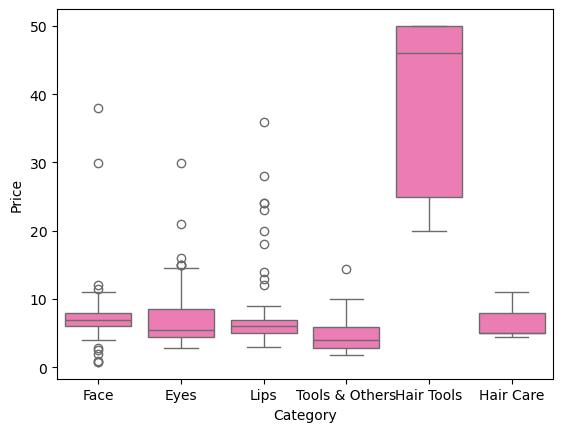

In [12]:
sns.boxplot(data=df, x='Category', y='Price',color='hotpink')

In [13]:
import re
# Define the new collection names as listed
collection_patterns = [
    r'Adventure\s*Time',
    r'Harry\s*Potter\s*\|\s*SHEGLAM\s*2\.0',
    r'Harley\s*Quinn',
    r'Rick\s*and\s*Morty',
    r'Crimson\s*Butterfly',
    r'Hello\s*Kitty\s*\|\s*SHEGLAM',
    r'The\s*Powerpuff\s*Girls',
    r'Ember\s*Rose',
    r'Cosmic\s*Come\s*Up',
    r'Harry\s*Potter\s*\|\s*SHEGLAM\s*1\.0',
    r'Chroma\s*Zone\s*2\.0',
    r'Care\s*Bears',
    r'Corpse\s*Bride',
    r'Marilyn\s*Monroe',
    r'Frida\s*Kahlo',
    r'Willy\s*Wonka'
]
# Combine into a single regex pattern (case-insensitive)
combined_pattern = re.compile('|'.join(collection_patterns), re.IGNORECASE)
# Filter rows where 'Name' contains a collection name
collections_df = df[df['Name'].str.contains(combined_pattern, na=False)].copy()
collections_df['collections'] = collections_df['Name'].str.extract(f"({combined_pattern.pattern})", flags=re.IGNORECASE)
# Select relevant columns
collections_df = collections_df[['collections', 'Name', 'Price', 'Best Seller']]
collections_df.reset_index(drop=True, inplace=True)
collections_df.head()

,collections,Name,Price,Best Seller
0,Rick and Morty,Rick and Morty X SHEGLAM Pickle Rick Setting S...,7.49,1
1,The Powerpuff Girls,The Powerpuff Girls X SHEGLAM Tough Love Shimm...,5.49,1
2,Adventure Time,Adventure Time | SHEGLAM Bubbline Cream Blush Duo,7.49,1
3,Adventure Time,Adventure Time | SHEGLAM Icy Hearts Multichrom...,7.49,1
4,Rick and Morty,Rick and Morty X SHEGLAM Mr. Sanchez Cream Blush,7.49,0


# **Data Analysis & Visualization 🎀**

In [14]:
# display price and stars statistics
df[['Price','Stars']].describe().round(2)

,Price,Stars
count,357.00,357.00
mean,8.52,3.81
std,8.33,1.94
min,0.79,0.00
25%,4.99,4.30
50%,5.99,4.80
75%,7.99,5.00
max,49.99,5.00


In [15]:
# see the percentage of best seller products and non best seller products
df['Best Seller'].value_counts()
df['Best Seller'].value_counts(normalize=True).mul(100).round(2) # in percentage

Best Seller
0    68.63
1    31.37
Name: proportion, dtype: float64

In [16]:
# see the average price/stars in every category
df.groupby('Category')[['Price','Stars']].mean().round(2)

,Price,Stars
Category,,
Eyes,6.93,3.75
Face,7.46,3.77
Hair Care,6.69,1.96
Hair Tools,37.70,4.66
Lips,7.73,3.70
Tools & Others,4.73,4.21


In [17]:
df.groupby('Subcategory')[['Price', 'Stars']].mean().round(2).sort_values('Price', ascending=False)

,Price,Stars
Subcategory,,
Hot-Air Brushes & Straight Hair Combs,49.42,4.21
Curling Tongs & Curling Wands,30.55,4.98
Hair Straightener Iron,19.99,5.00
Lip Kit,11.99,2.93
Eyeshadow Palette,10.22,3.81
Makeup Bag,9.12,4.27
Lip Gloss,8.86,3.61
Brush Set,8.49,4.70
Highlighter,8.45,3.74


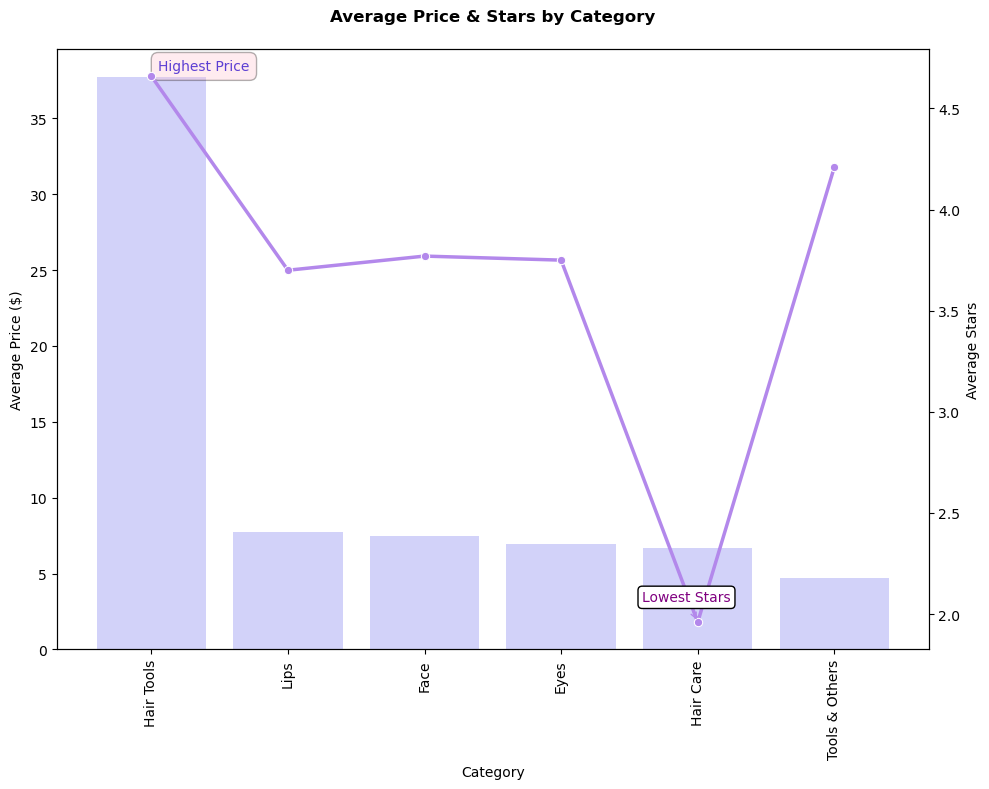

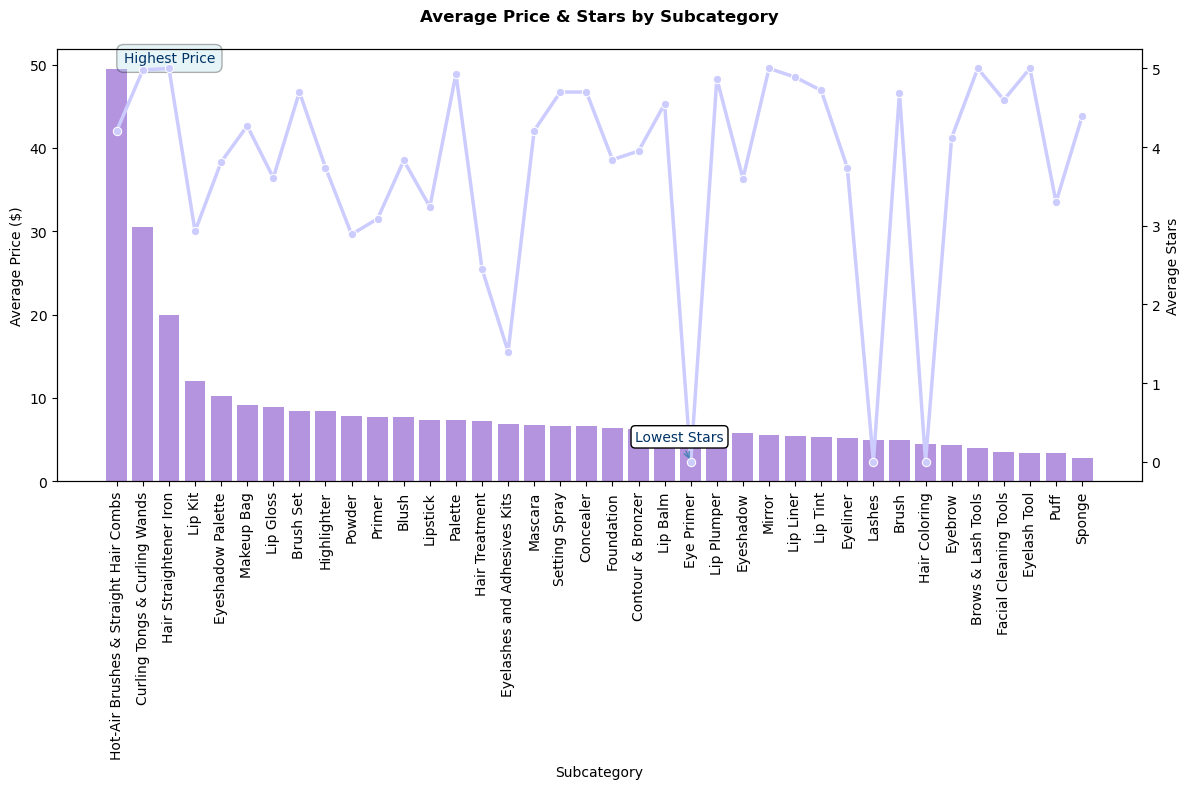

In [18]:
# see the average price/stars in every category
df.groupby('Category')[['Price','Stars']].mean().round(2)
# Prepare data
subcat_stats = df.groupby('Category')[['Price','Stars']].mean().round(2).sort_values('Price', ascending=False)
plt.figure(figsize=(10,8))
ax = sns.barplot(x=subcat_stats.index, y='Price', data=subcat_stats, color='#CCCCFF')  
plt.xticks(rotation=90)
plt.ylabel('Average Price ($)')
plt.title('Average Price & Stars by Category', pad=20, color='black', fontweight='bold')
ax2 = ax.twinx()
sns.lineplot(x=subcat_stats.index, y='Stars', data=subcat_stats,
             color='#B388EB', marker='o', ax=ax2, linewidth=2.5)  
ax2.set_ylabel('Average Stars')
# Highlight key findings with cuter styles
ax.annotate('Highest Price', xy=(0, subcat_stats.Price.iloc[0]),
            xytext=(5, 5), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.5', fc='#FFC0CB', alpha=0.3),
            color='#5D3FD3')
ax2.annotate('Lowest Stars', xy=(subcat_stats.Stars.idxmin(), subcat_stats.Stars.min()),
             xytext=(-40, 15), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', color='#B388EB'),
             bbox=dict(boxstyle='round', fc='white'),
             color='#800080')  # Purple
plt.tight_layout()
plt.show()

# Average price/stars per Subcategory
subcat_stats = df.groupby('Subcategory')[['Price', 'Stars']].mean().round(2).sort_values('Price', ascending=False)
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=subcat_stats.index, y='Price', data=subcat_stats, color='#B388EB')  
plt.xticks(rotation=90)
plt.ylabel('Average Price ($)')
plt.title('Average Price & Stars by Subcategory', pad=20, color='black', fontweight='bold')
ax2 = ax.twinx()
sns.lineplot(x=subcat_stats.index, y='Stars', data=subcat_stats,
             color='#CCCCFF', marker='o', ax=ax2, linewidth=2.5)  
ax2.set_ylabel('Average Stars')
ax.annotate('Highest Price', xy=(0, subcat_stats.Price.iloc[0]),
            xytext=(5, 5), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.5', fc='#ADD8E6', alpha=0.3),  
            color='#003366')

ax2.annotate('Lowest Stars', xy=(subcat_stats.Stars.idxmin(), subcat_stats.Stars.min()),
             xytext=(-40, 15), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', color='#4682B4'),
             bbox=dict(boxstyle='round', fc='white'),
             color='#003366') 
plt.tight_layout()
plt.show()

          Price     Stars
Price  1.000000  0.056445
Stars  0.056445  1.000000


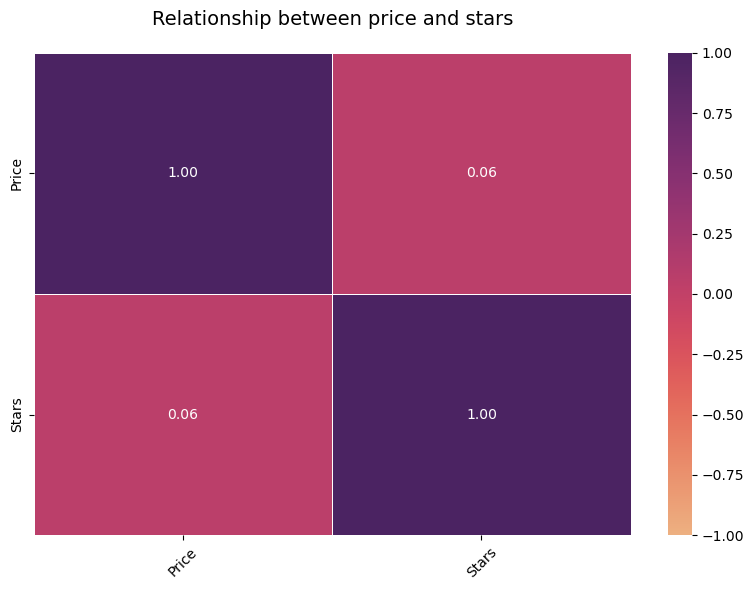

In [19]:
# check if there is a relationship between the price and the stars of the product
print(df[['Price', 'Stars']].corr())
plt.figure(figsize=(8, 6))
sns.heatmap(df[['Price', 'Stars']].corr(),annot=True,cmap='flare',vmin=-1,vmax=1,linewidths=0.5,fmt=".2f")
plt.title("Relationship between price and stars", fontsize=14, pad=20)
plt.xticks(rotation=45) 
plt.tight_layout()     
plt.show()

Average Price and Stars in best sellers:

                 Price  Stars
Non-Best Seller   9.51   3.66
Best Seller       6.36   4.14


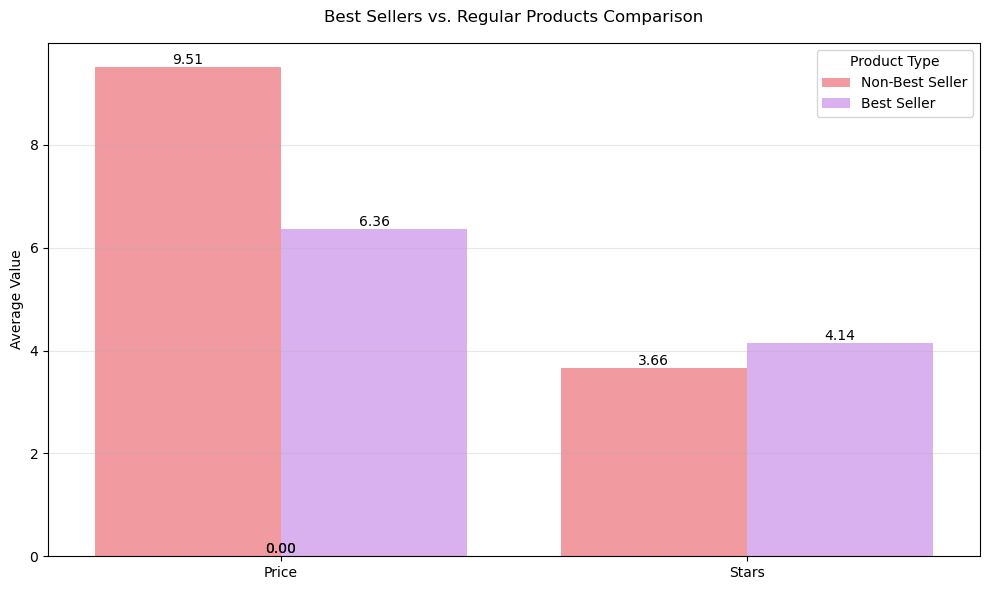

In [20]:
#compares the average price and star rating of 'Best Seller' products and 'Non-Best Seller' products.
# Group by 'Best Seller' and calculate the mean of Price and Stars
avg_values = df.groupby('Best Seller')[['Price', 'Stars']].mean().round(2)
# Rename index for better readability
avg_values.index = ['Non-Best Seller', 'Best Seller']
print("Average Price and Stars in best sellers:\n")
print(avg_values)
plt.figure(figsize=(10, 6))
# Change 'Best Seller' to 'index' after resetting index
melted = avg_values.reset_index().melt(id_vars='index',  # Changed id_vars to 'index'
                                     value_vars=['Price', 'Stars'],
                                     var_name='Metric')
# Rename the 'index' column for clarity in the plot
melted = melted.rename(columns={'index': 'Best Seller'}) # Rename column to 'Best Seller'
# Create plot
ax = sns.barplot(x='Metric', y='value', hue='Best Seller',
                data=melted, palette=['#FF8C94', '#DCA7F8'])  
# Add value labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
               (p.get_x() + p.get_width()/2., p.get_height()),
               ha='center', va='center',
               xytext=(0, 5),
               textcoords='offset points')

plt.title('Best Sellers vs. Regular Products Comparison', pad=15)
plt.ylabel('Average Value')
plt.xlabel('')
plt.legend(title='Product Type', bbox_to_anchor=(1,1))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [21]:
# count the number of best seller products in each category
# Filter best sellers
best_sellers = df[df['Best Seller'] == 1 ]
best_seller_count = best_sellers['Category'].value_counts().reset_index()
best_seller_count.columns = ['Category', 'Best Seller Count'] # rename the columns
print(best_seller_count)

# "Face" category has the highest number of best seller products.
# "Hair Care" category has the lowest number of best seller products

         Category  Best Seller Count
0            Face                 42
1            Eyes                 27
2            Lips                 21
3  Tools & Others                 20
4       Hair Care                  2


In [22]:
# Interactive sunburst chart showing the number of best-selling products by category,
import plotly.express as px
best_sellers = df[df['Best Seller'] == 1]
best_sellers_cat = best_sellers['Category'].value_counts().reset_index()
best_sellers_cat.columns = ['Category', 'Count']
color_map = {
    'Face': '#FFB6C1',
    'Lips': '#FF69B4',
    'Eyes': '#DB7093',
    'Hair Tools': '#FFA6C9',
    'Hair Care': '#FFC0CB',
    'Tools & Others': '#F4C2C2'}
fig = px.sunburst(
    best_sellers_cat,
    path=['Category'],
    values='Count',
    color='Category',
    color_discrete_map=color_map,
    title='<b>Best Sellers by Category</b><br><i>Each category has a pink tone</i>')
fig.update_traces(
    marker=dict(line=dict(color='white', width=1)),
    hovertemplate='<b>%{label}</b><br>Best Sellers: %{value}<extra></extra>',
    textinfo='label+percent entry',
    insidetextorientation='radial')
fig.update_layout(
    paper_bgcolor='#FFF0F5',
    margin=dict(t=100, l=50, r=0, b=0),
    height=600,
    width=800,
    title_font=dict(size=18, color='#FF1493'),
    uniformtext=dict(minsize=8, mode='hide'),
    clickmode='event+select')
fig.show()

In [23]:
# calculate the average price in each collection
collections_df.groupby('collections')['Price'].mean().round(2)
# "Adventure Time" collection has the highest average price.
# "The Powerpuff Girls" collection has the lowest average price.

collections
Adventure Time          8.28
Care Bears              8.75
Ember Rose             12.82
Frida Kahlo             5.52
Harley Quinn            7.66
Marilyn Monroe          8.03
Rick and Morty         11.34
The Powerpuff Girls     7.24
Name: Price, dtype: float64

In [24]:
# calculate the average price in each collection
# Prepare data
import plotly.graph_objects as go
avg_price = (collections_df.groupby('collections')['Price']
             .mean()
             .round(2)
             .sort_values(ascending=False)
             .reset_index())
# Create the figure
fig = go.Figure()
# Add floating bubbles
for _, row in avg_price.iterrows():
    fig.add_trace(go.Scatter(
        x=[row['collections']],
        y=[row['Price']],
        mode='markers+text',
        marker=dict(
            size=row['Price'] * 3,  
            color='pink',  
            opacity=0.8,
            line=dict(width=1, color='black')  
        ),
        text=[f"${row['Price']}"],
        textposition='middle center',
        showlegend=False))
# Layout adjustments
fig.update_layout(
    title='Average Price by Collection',
    yaxis=dict(title='Average Price (USD)'),
    xaxis=dict(title=None),
    plot_bgcolor='#f9f9f9',
    margin=dict(t=60, b=60),)
# Show the plot
fig.show()

In [25]:
# calculate total number of products in each collection
total_counts = collections_df['collections'].value_counts().rename('Total Products')
# calculate number of best sellers in each collection
best_seller_counts = collections_df[collections_df['Best Seller'] == 1]['collections'].value_counts().rename('Best Seller Products')
# make a DataFrame containing total_counts and best_seller_counts
collection_summary = pd.concat([total_counts, best_seller_counts], axis=1).fillna(0)
# convert best seller counts to integers
collection_summary['Best Seller Products'] = collection_summary['Best Seller Products'].astype(int)
# add the best seller percentage column
collection_summary['Best Seller %'] = (
    (collection_summary['Best Seller Products'] / collection_summary['Total Products']) * 100
).round(2)

print(collection_summary)
# Insights:
# 1)
# "Rick and Morty" collection has the highest number of products.
# "Frida Kahlo" collection has the lowest number of products.
# 2)
# "Adventure Time" collection has the highest number of best seller products.
# this also shows that some collections has no best seller products.
# 3)
# 100% of the products in the "Adventure Time" collection is a best seller product

                     Total Products  Best Seller Products  Best Seller %
collections                                                             
Rick and Morty                    8                     1          12.50
Adventure Time                    7                     6          85.71
Ember Rose                        6                     0           0.00
Harley Quinn                      6                     0           0.00
Marilyn Monroe                    5                     1          20.00
Care Bears                        5                     0           0.00
The Powerpuff Girls               4                     2          50.00
Frida Kahlo                       3                     0           0.00


In [27]:
#a bar chart comparing the total number of products and best sellers in each collection.
summary = collections_df.groupby('collections')['Best Seller'].agg(
    Total='count',
    Best='sum'
).reset_index()
fig = go.Figure(data=[
    go.Bar(
        x=summary['collections'],
        y=summary['Total'],
        name='Total Products',
        marker_color='#FFB6C1',
        text=summary['Total'],
        textposition='outside'
    ),
    go.Bar(
        x=summary['collections'],
        y=summary['Best'],
        name='Best Sellers',
        marker_color='#9370DB',
        text=summary['Best'],
        textposition='outside'
    )])
fig.update_layout(
    title="📦 Total vs Best Sellers by Collection",
    barmode='group',
    xaxis_title='Collection',
    yaxis_title='Count',
    plot_bgcolor='#FFF5F7',
    paper_bgcolor='#FFF5F7',
    height=500,
    margin=dict(t=50, b=50))
fig.show()

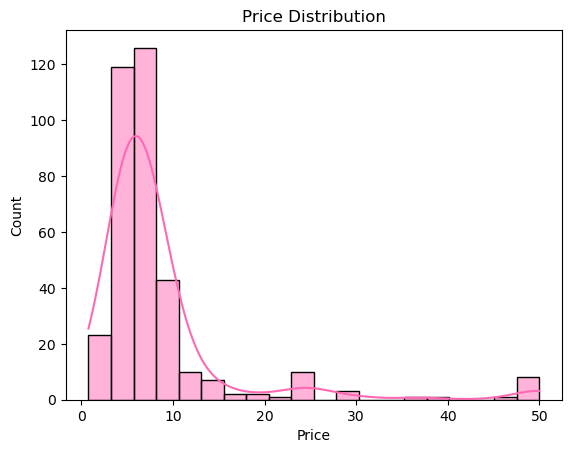

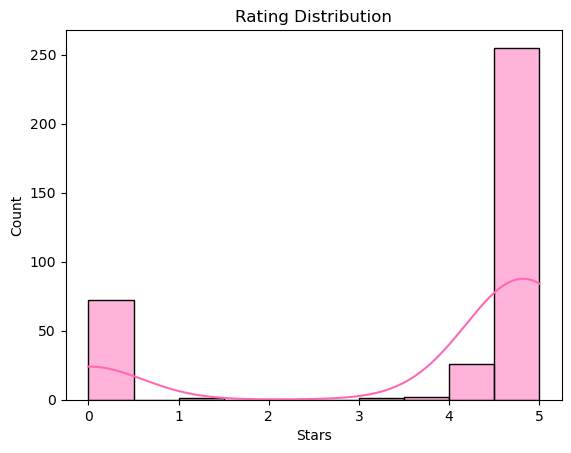

In [28]:
# the Price Distribution tells us that most products on the site are budget-friendly
sns.histplot(df['Price'], bins=20, kde=True,color='hotpink')
plt.title('Price Distribution')
plt.show()
# the Rating Distribution shows that most products have high rating
sns.histplot(df['Stars'], bins=10, kde=True,color='hotpink')
plt.title('Rating Distribution')
plt.show()

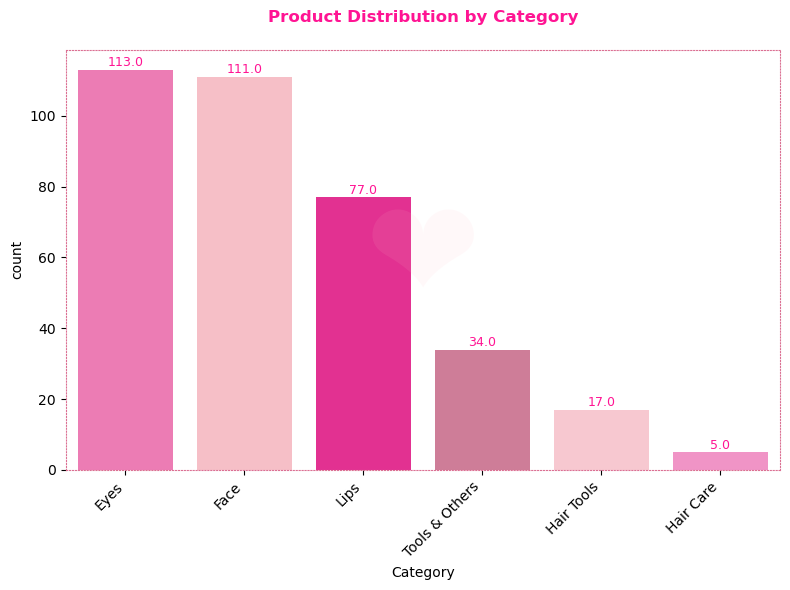

In [29]:
# count the number of products in each category
# Set available fonts
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Liberation Sans', 'Arial Unicode MS']
# Create figure with white background
plt.figure(figsize=(8,6))
ax = sns.countplot(x='Category', data=df,order=df['Category'].value_counts().index,hue='Category',
                  palette=['#FFB6C1', '#FF69B4', '#FF1493',
                          '#DB7093', '#FFC0CB', '#FF85C7'],legend=False)
# Set white background (only change made)
ax.set_facecolor('white')
plt.gcf().set_facecolor('white')
# Keep original pink dotted borders
for spine in ax.spines.values():
    spine.set_linestyle(':')
    spine.set_color('#DB7093')  
    #spine.set_linewidth(1.5)
# Keep original pink heart watermark
heart = plt.Text(0.5, 0.5, '❤',fontsize=100,color='pink',alpha=0.1,ha='center',va='center',transform=ax.transAxes)
ax.add_artist(heart)
plt.xticks(rotation=45, ha='right')
plt.title('Product Distribution by Category',
          fontsize=12, pad=20, color='#FF1493', fontweight='bold')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
               (p.get_x() + p.get_width()/2., p.get_height()),ha='center', va='center',xytext=(0, 5),
               textcoords='offset points',
               color='#FF1493',
               fontsize=9)
plt.tight_layout()
plt.show()

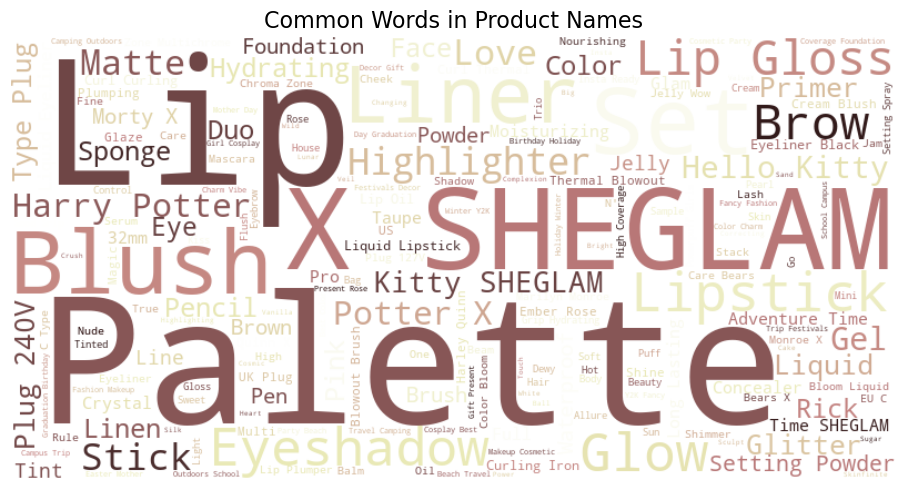

In [31]:
#Generates a word cloud visualization based on the most common words in product names
from wordcloud import WordCloud
text = ' '.join(df['Name'].dropna().tolist())
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='pink'
).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in Product Names', fontsize=16)
plt.tight_layout()
plt.show()

In [32]:
# Create the treemap with custom category colors
pink_palette = [
    "#FFC0CB",  # Pink
    "#FFB6C1",  # Light Pink
    "#FF69B4",  # Hot Pink
    "#DB7093",  # Pale Violet Red
    "#FF1493",  # Deep Pink
    "#E75480",  # Dark Pink
    "#FFA6C9",  # Pastel Pink
    "#F4C2C2",  # Baby Pink
]
# Get unique categories
categories = df['Category'].unique()
# Create the color map
color_map = {category: pink_palette[i % len(pink_palette)] for i, category in enumerate(categories)}
fig = px.treemap(
    df,
    path=['Category', 'Subcategory'],
    title='Product Distribution by Category and Subcategory',
    color='Category',
    color_discrete_map=color_map
)
# Simple styling
fig.update_layout(
    paper_bgcolor='#FFF5F7',  
    margin=dict(t=50, l=0, r=0, b=0))
fig.show()

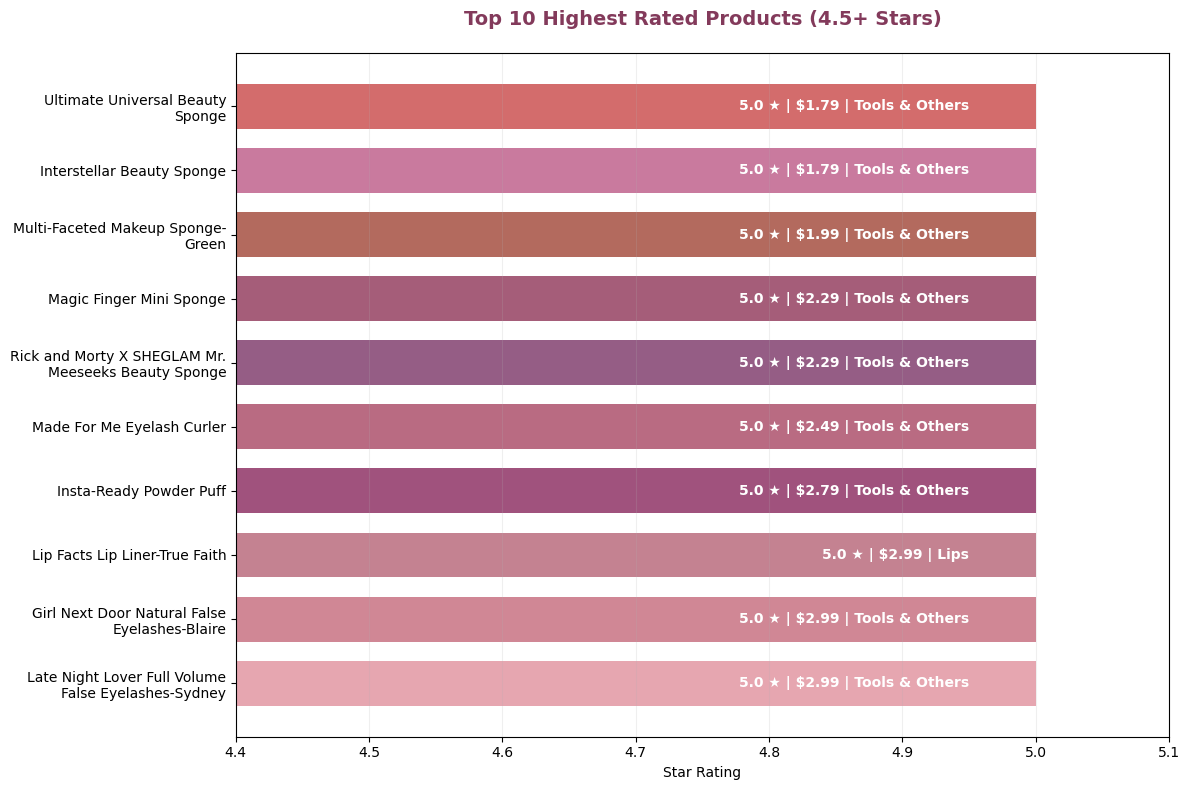

In [33]:
# Top 10 rated products
top_rated = df[df['Stars'] >= 4.5].sort_values(by=['Stars', 'Price'], ascending=[False, True]).head(10)
plt.figure(figsize=(12, 8))
girly_shades = [
    '#D36C6C',  # Dusty rose
    '#C97A9E',  # Blush mauve
    '#B36A5E',  # Terracotta pink
    '#A55D79',  # Rosewood
    '#955D85',  # Mauve
    '#B96B82',  # Soft berry
    '#A0527D',  # Plum pink
    '#C48291',  # Warm pink
    '#D08795',  # Faded red
    '#E6A6B0'   # Rose quartz
]
bars = plt.barh(
    top_rated['Name'].str.wrap(30),
    top_rated['Stars'],
    color=girly_shades[:len(top_rated)],
    height=0.7)
for bar, price, category in zip(bars, top_rated['Price'], top_rated['Category']):
    width = bar.get_width()
    plt.text(
        width - 0.05,
        bar.get_y() + bar.get_height()/2,
        f"{width:.1f} ★ | ${price} | {category}",
        va='center',
        ha='right',
        color='white',
        fontweight='bold')
plt.title('Top 10 Highest Rated Products (4.5+ Stars)', pad=20, fontsize=14, fontweight='bold', color='#833A5B')
plt.xlabel('Star Rating')
plt.xlim(4.4, 5.1)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.2)
plt.tight_layout()
plt.show()

# **MongoDB 🎀**

In [30]:
from pymongo import MongoClient
client = MongoClient('mongodb://localhost:27017/')  
db = client['sheglam']  
collection = db['products'] 
records = df.to_dict(orient='records')
collection.insert_many(records)
print("Data has been inserted into MongoDB!")

Data has been inserted into MongoDB!


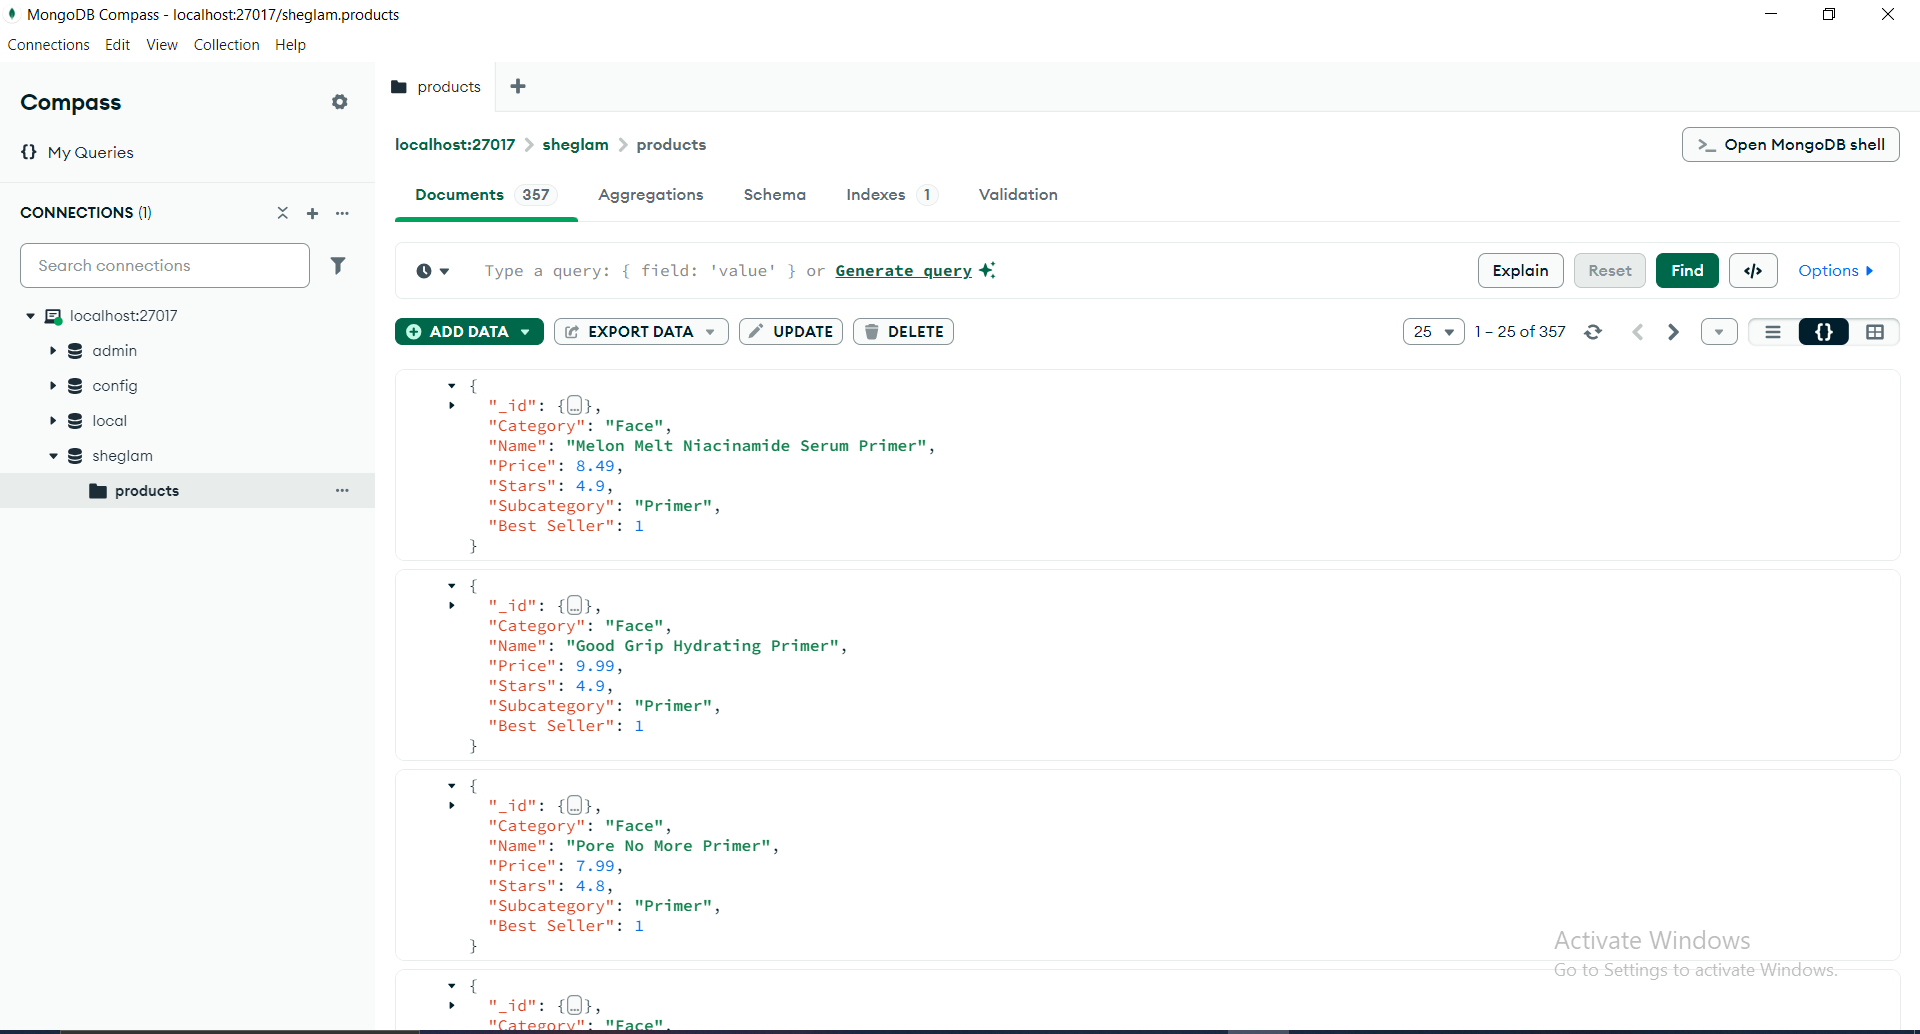

In [41]:
from IPython.display import Image
Image(filename='Mongoooooooo.PNG')

# **Bonus Task 🎀**

[🎀 Link for Explore the SHEGLAM Streamlit App](https://sheglam-mtzzprwatu9ibsx7wywcnu.streamlit.app/)

## **some screenshots from our app**

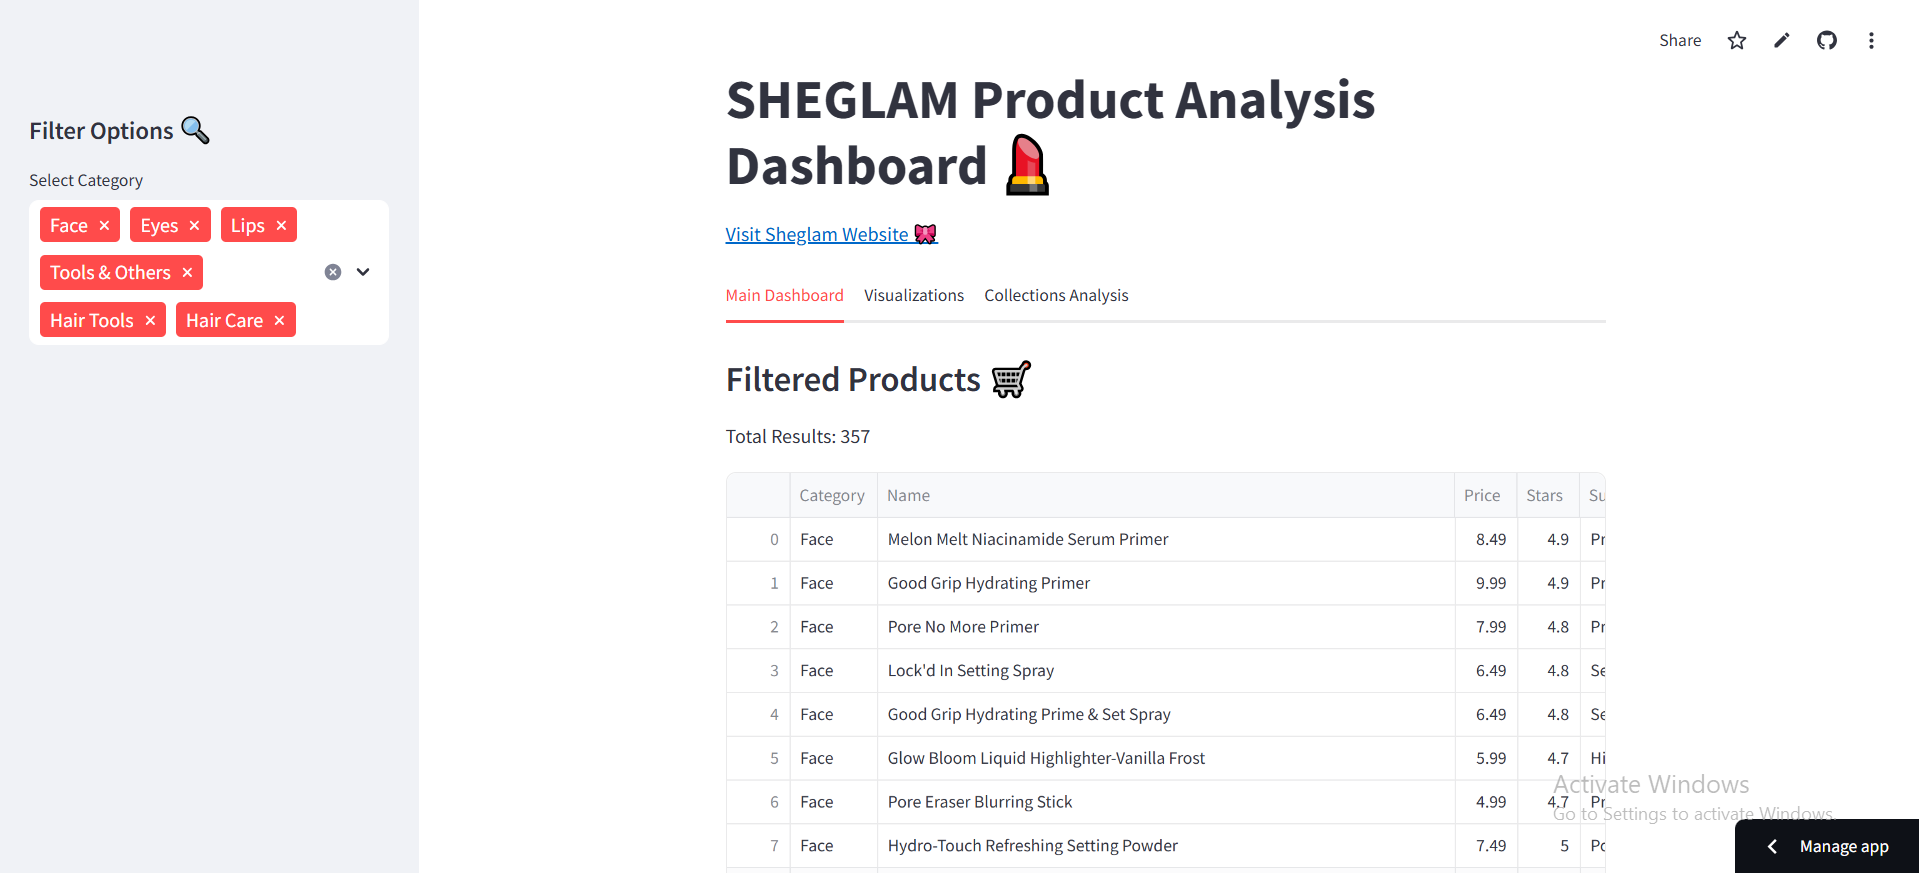

In [46]:
Image(filename='stream1.PNG')

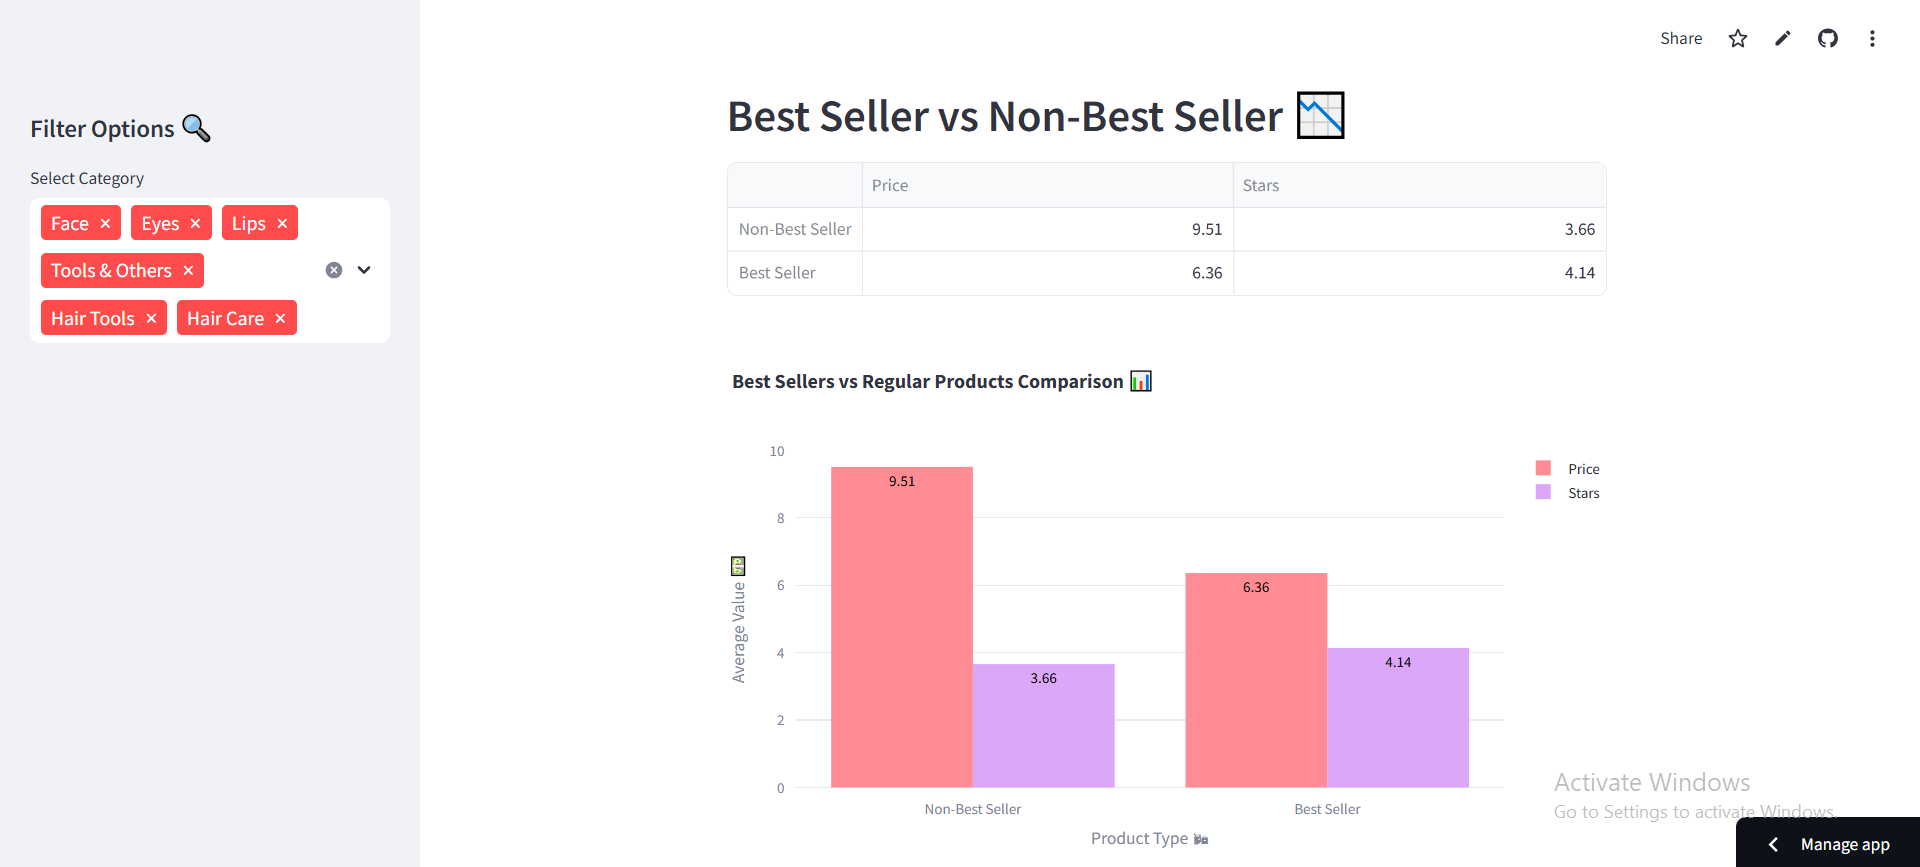

In [49]:
Image(filename='stream2.PNG')

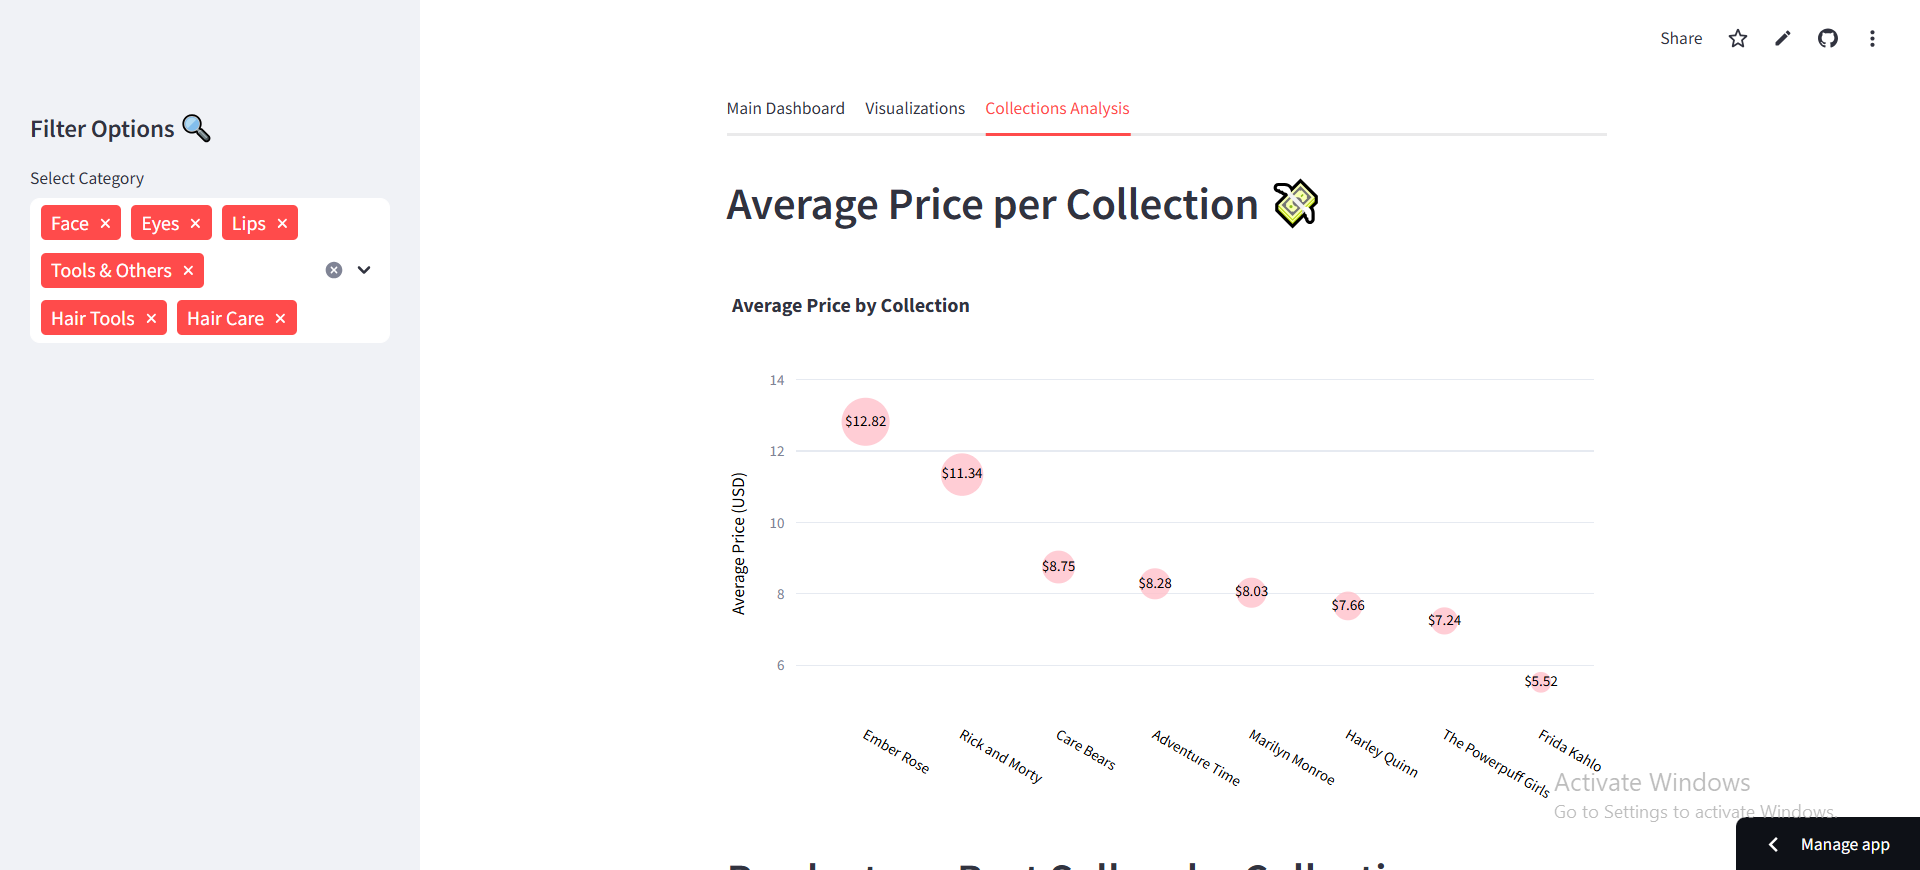

In [51]:
Image(filename='stream3.PNG')

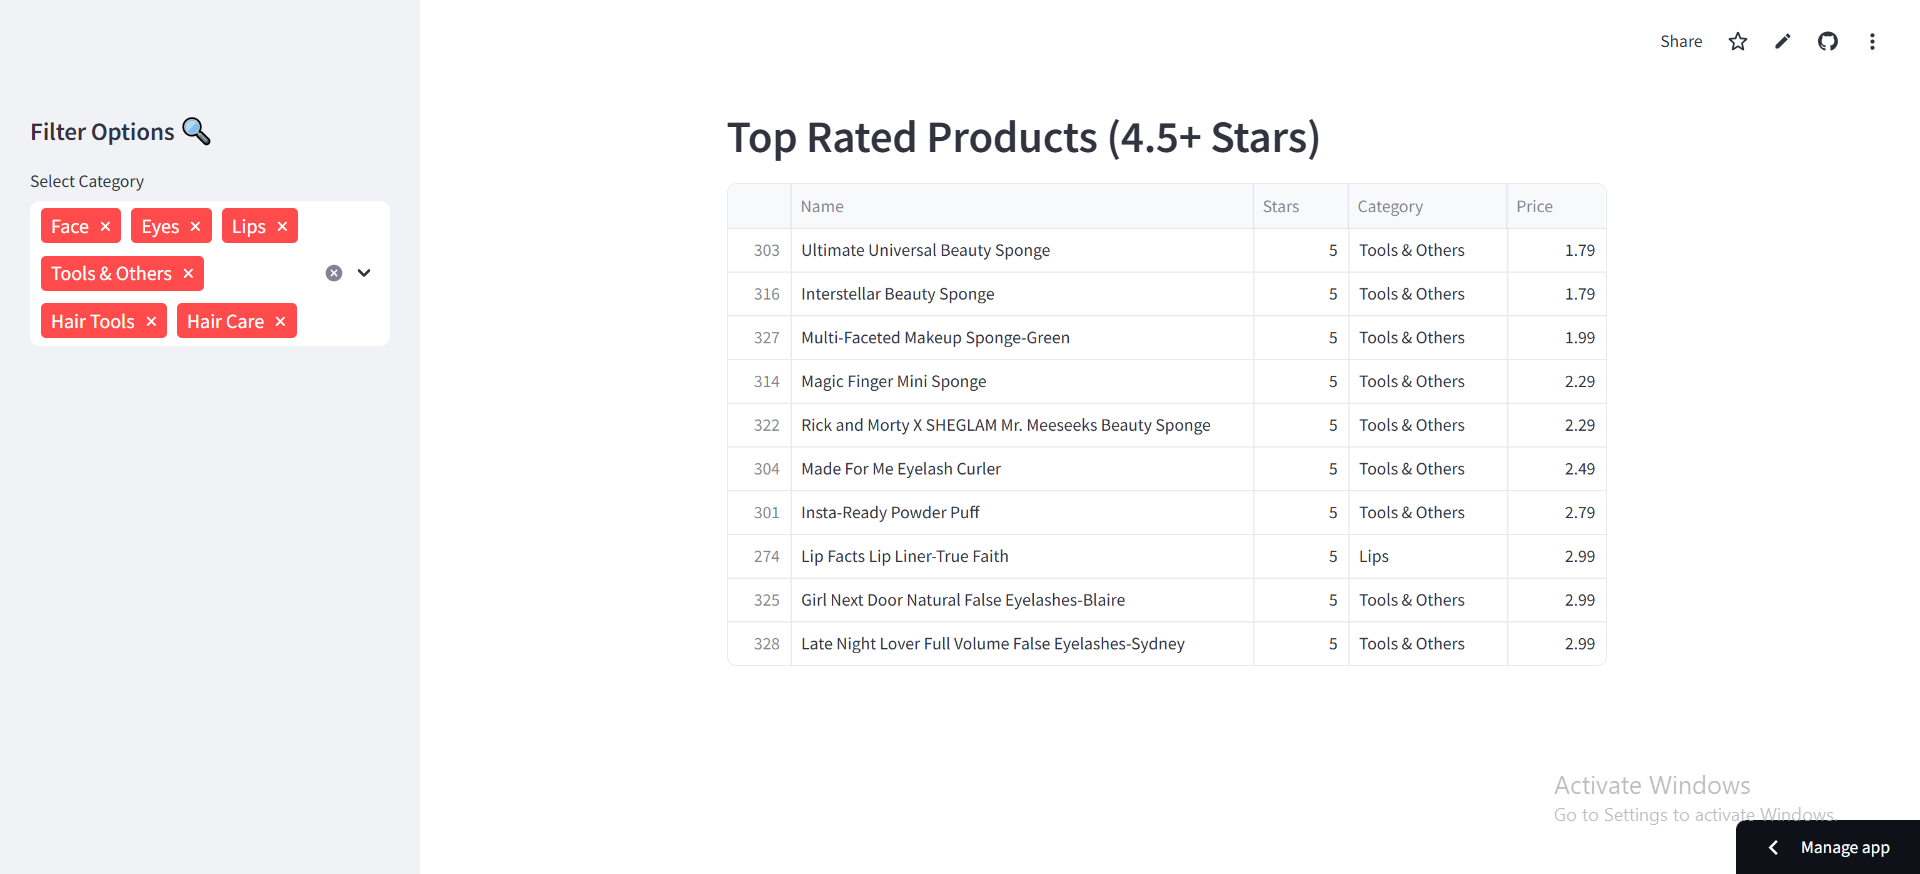

In [57]:
Image(filename='stream4.PNG')